In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


## Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)
train_size=0.00108/64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss(filter_dim=1, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)
awi2D     = AWLoss(filter_dim=2, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-7)
awi3D     = AWLoss(filter_dim=3, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-7)


No GPU available! Running on CPU


## Datasets and Dataloaders

In [3]:
# Train Transforms
train_transform = Compose([
    Resize(28),
    # Grayscale(),
])

# Datasets and dataloaders
ds = CIFAR10("../data", download=True, train=True, transform=train_transform)

try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]

X_train, y_train = torch.from_numpy(ds.data[train_idx]) / 255., torch.tensor(ds.targets)[train_idx]
X_train = X_train.permute(0, 3, 1, 2)
trainds = TransformTensorDataset(X_train.float(), y_train.float(), transform=train_transform)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Files already downloaded and verified
Trainable Images: 1
torch.Size([1, 3, 28, 28]) 0.0673472136259079 0.9533613324165344


## Autoencoder (CNN)

In [4]:
def model_instance():
    return CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)

model_sample = model_instance()

print(model_sample)
print(X.shape, model_sample(X).shape)

CAE28(
  (activation): Mish()
  (sigmoid): Sigmoid()
  (e_cv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
  (e_cv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (e_cv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (e_fc5): Linear(in_features=128, out_features=32, bias=True)
  (d_fc1): Linear(in_features=32, out_features=128, bias=True)
  (d_cv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3))
  (d_cv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
  (d_cv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(3, 3))
)
torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


## Training MSE Loss



Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 0, 'loss': 118.8561019897461, 'mse (validation)': 0.050417717546224594, 'kl_loss': 0.0}


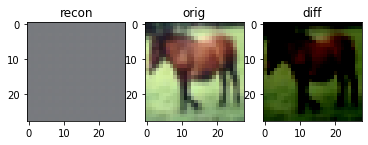

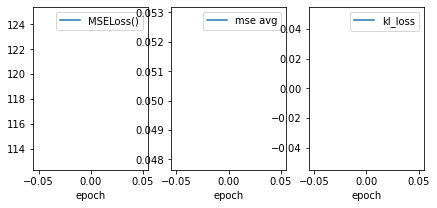

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:35
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:04
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:53
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:47
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:47
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:44
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:33
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:32
  9% (9 of 100) |##                      | Elapsed Time: 0:00:03 ETA:   0:00:36
 10% (10 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:35
 11% (11 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:31
 12% (12 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:31
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 54.5502815246582, 'mse (validation)': 0.02161012962460518, 'kl_loss': 0.0}


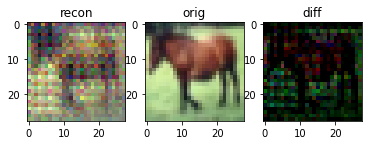

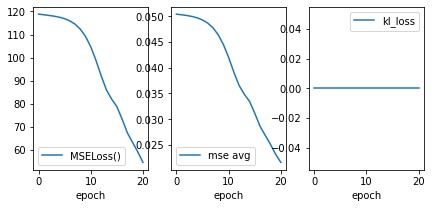

 21% (21 of 100) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:38
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:34
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:32
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:31
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:32
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:32
 27% (27 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:30
 28% (28 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:24
 29% (29 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:28
 30% (30 of 100) |######                 | Elapsed Time: 0:00:12 ETA:   0:00:27
 31% (31 of 100) |#######                | Elapsed Time: 0:00:12 ETA:   0:00:26
 32% (32 of 100) |#######                | Elapsed Time: 0:00:12 ETA:   0:00:24
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 13.824796676635742, 'mse (validation)': 0.005553101189434528, 'kl_loss': 0.0}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


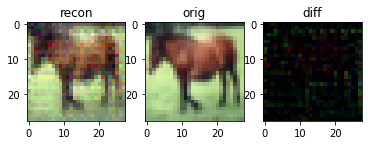

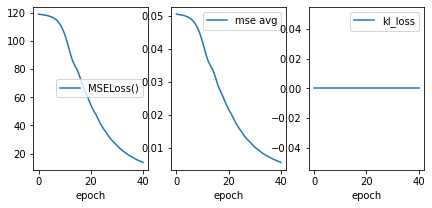

 41% (41 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:30
 42% (42 of 100) |#########              | Elapsed Time: 0:00:17 ETA:   0:00:29
 43% (43 of 100) |#########              | Elapsed Time: 0:00:17 ETA:   0:00:29
 44% (44 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:30
 45% (45 of 100) |##########             | Elapsed Time: 0:00:18 ETA:   0:00:28
 46% (46 of 100) |##########             | Elapsed Time: 0:00:18 ETA:   0:00:25
 47% (47 of 100) |##########             | Elapsed Time: 0:00:18 ETA:   0:00:19
 48% (48 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:21
 49% (49 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:20
 50% (50 of 100) |###########            | Elapsed Time: 0:00:20 ETA:   0:00:18
 51% (51 of 100) |###########            | Elapsed Time: 0:00:20 ETA:   0:00:20
 52% (52 of 100) |###########            | Elapsed Time: 0:00:21 ETA:   0:00:20
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 5.112183570861816, 'mse (validation)': 0.002071059076115489, 'kl_loss': 0.0}


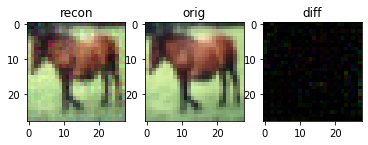

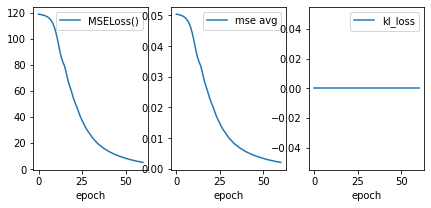

 61% (61 of 100) |##############         | Elapsed Time: 0:00:25 ETA:   0:00:22
 62% (62 of 100) |##############         | Elapsed Time: 0:00:25 ETA:   0:00:21
 63% (63 of 100) |##############         | Elapsed Time: 0:00:25 ETA:   0:00:19
 64% (64 of 100) |##############         | Elapsed Time: 0:00:26 ETA:   0:00:18
 65% (65 of 100) |##############         | Elapsed Time: 0:00:26 ETA:   0:00:17
 66% (66 of 100) |###############        | Elapsed Time: 0:00:27 ETA:   0:00:16
 67% (67 of 100) |###############        | Elapsed Time: 0:00:27 ETA:   0:00:11
 68% (68 of 100) |###############        | Elapsed Time: 0:00:27 ETA:   0:00:11
 69% (69 of 100) |###############        | Elapsed Time: 0:00:28 ETA:   0:00:12
 70% (70 of 100) |################       | Elapsed Time: 0:00:28 ETA:   0:00:12
 71% (71 of 100) |################       | Elapsed Time: 0:00:28 ETA:   0:00:10
 72% (72 of 100) |################       | Elapsed Time: 0:00:29 ETA:   0:00:10
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 2.246513843536377, 'mse (validation)': 0.0009233669843524694, 'kl_loss': 0.0}


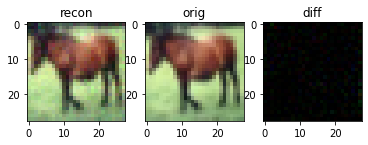

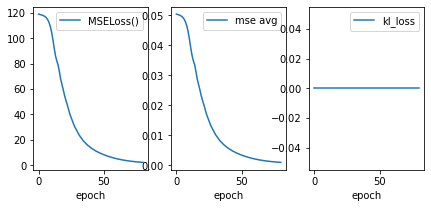

 81% (81 of 100) |##################     | Elapsed Time: 0:00:33 ETA:   0:00:10
 82% (82 of 100) |##################     | Elapsed Time: 0:00:33 ETA:   0:00:09
 83% (83 of 100) |###################    | Elapsed Time: 0:00:34 ETA:   0:00:07
 84% (84 of 100) |###################    | Elapsed Time: 0:00:34 ETA:   0:00:07
 85% (85 of 100) |###################    | Elapsed Time: 0:00:34 ETA:   0:00:07
 86% (86 of 100) |###################    | Elapsed Time: 0:00:35 ETA:   0:00:06
 87% (87 of 100) |####################   | Elapsed Time: 0:00:35 ETA:   0:00:04
 88% (88 of 100) |####################   | Elapsed Time: 0:00:35 ETA:   0:00:04
 89% (89 of 100) |####################   | Elapsed Time: 0:00:36 ETA:   0:00:04
 90% (90 of 100) |####################   | Elapsed Time: 0:00:36 ETA:   0:00:03
 91% (91 of 100) |####################   | Elapsed Time: 0:00:36 ETA:   0:00:03
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:37 ETA:   0:00:02
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 1.2644038200378418, 'mse (validation)': 0.0005236376309767365, 'kl_loss': 0.0}


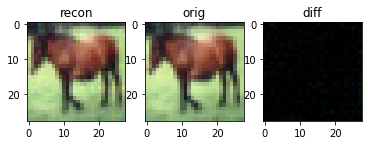

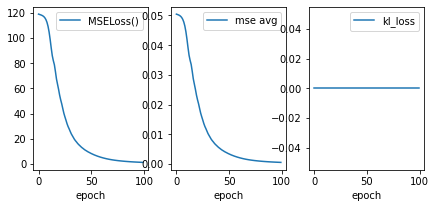

100% (100 of 100) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


In [5]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, l2loss, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [6]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, l2loss, device=device)

## Training AWLoss1D



Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /tmp/pip-req-build-9n7gsq15/aten/src/ATen/native/Copy.cpp:219.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 0, 'loss': 0.7082381248474121, 'mse (validation)': 0.049848560243844986, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


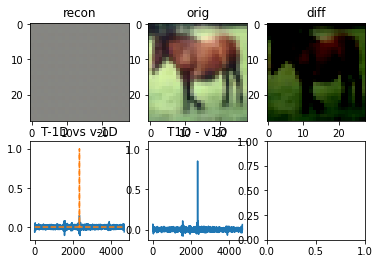

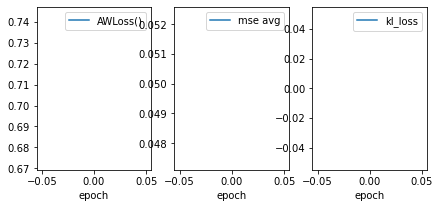

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:49
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:19
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:03
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:56
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:50
  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:39
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:37
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:34
  9% (9 of 100) |##                      | Elapsed Time: 0:00:04 ETA:   0:00:37
 10% (10 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:39
 11% (11 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:35
 12% (12 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:35
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 0.6479297876358032, 'mse (validation)': 0.04942210018634796, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


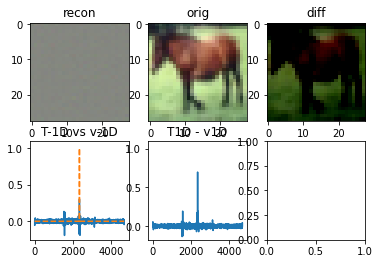

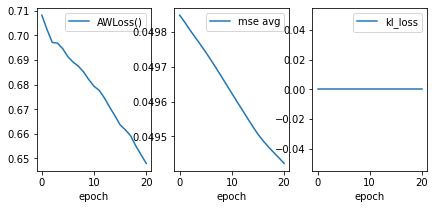

 21% (21 of 100) |####                   | Elapsed Time: 0:00:10 ETA:   0:00:54
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:55
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:47
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:44
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:11 ETA:   0:00:42
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:12 ETA:   0:00:40
 27% (27 of 100) |######                 | Elapsed Time: 0:00:12 ETA:   0:00:28
 28% (28 of 100) |######                 | Elapsed Time: 0:00:12 ETA:   0:00:30
 29% (29 of 100) |######                 | Elapsed Time: 0:00:13 ETA:   0:00:30
 30% (30 of 100) |######                 | Elapsed Time: 0:00:13 ETA:   0:00:29
 31% (31 of 100) |#######                | Elapsed Time: 0:00:14 ETA:   0:00:26
 32% (32 of 100) |#######                | Elapsed Time: 0:00:14 ETA:   0:00:29
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 0.5884367227554321, 'mse (validation)': 0.04915403574705124, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


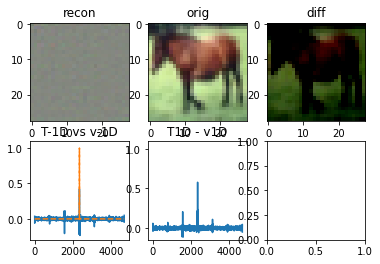

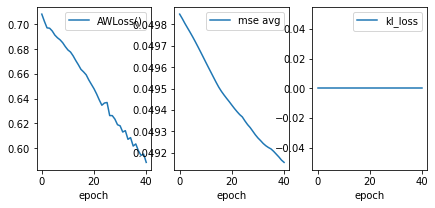

 41% (41 of 100) |#########              | Elapsed Time: 0:00:19 ETA:   0:00:45
 42% (42 of 100) |#########              | Elapsed Time: 0:00:19 ETA:   0:00:41
 43% (43 of 100) |#########              | Elapsed Time: 0:00:20 ETA:   0:00:39
 44% (44 of 100) |##########             | Elapsed Time: 0:00:20 ETA:   0:00:34
 45% (45 of 100) |##########             | Elapsed Time: 0:00:21 ETA:   0:00:34
 46% (46 of 100) |##########             | Elapsed Time: 0:00:21 ETA:   0:00:22
 47% (47 of 100) |##########             | Elapsed Time: 0:00:21 ETA:   0:00:22
 48% (48 of 100) |###########            | Elapsed Time: 0:00:22 ETA:   0:00:23
 49% (49 of 100) |###########            | Elapsed Time: 0:00:22 ETA:   0:00:23
 50% (50 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:20
 51% (51 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:19
 52% (52 of 100) |###########            | Elapsed Time: 0:00:23 ETA:   0:00:18
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 0.5414518713951111, 'mse (validation)': 0.048877838999032974, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


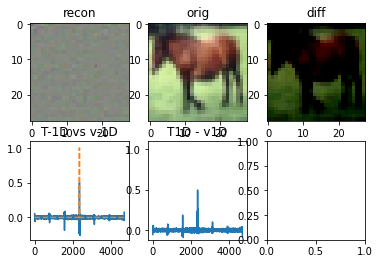

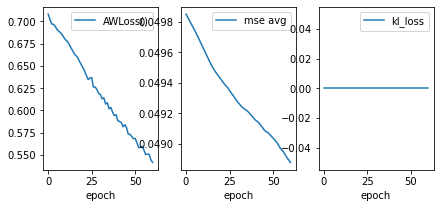

 61% (61 of 100) |##############         | Elapsed Time: 0:00:28 ETA:   0:00:26
 62% (62 of 100) |##############         | Elapsed Time: 0:00:29 ETA:   0:00:27
 63% (63 of 100) |##############         | Elapsed Time: 0:00:29 ETA:   0:00:26
 64% (64 of 100) |##############         | Elapsed Time: 0:00:29 ETA:   0:00:22
 65% (65 of 100) |##############         | Elapsed Time: 0:00:30 ETA:   0:00:21
 66% (66 of 100) |###############        | Elapsed Time: 0:00:30 ETA:   0:00:15
 67% (67 of 100) |###############        | Elapsed Time: 0:00:31 ETA:   0:00:13
 68% (68 of 100) |###############        | Elapsed Time: 0:00:31 ETA:   0:00:13
 69% (69 of 100) |###############        | Elapsed Time: 0:00:32 ETA:   0:00:13
 70% (70 of 100) |################       | Elapsed Time: 0:00:32 ETA:   0:00:12
 71% (71 of 100) |################       | Elapsed Time: 0:00:32 ETA:   0:00:11
 72% (72 of 100) |################       | Elapsed Time: 0:00:33 ETA:   0:00:10
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 0.5057333707809448, 'mse (validation)': 0.04848919436335564, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


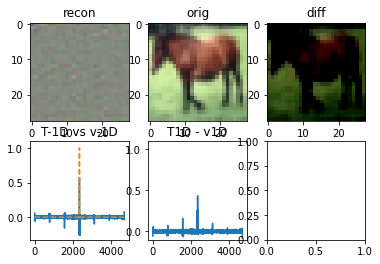

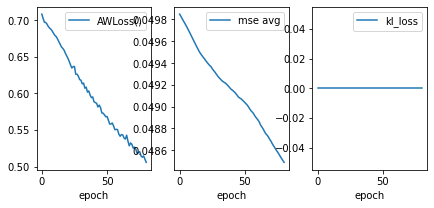

 81% (81 of 100) |##################     | Elapsed Time: 0:00:37 ETA:   0:00:13
 82% (82 of 100) |##################     | Elapsed Time: 0:00:38 ETA:   0:00:12
 83% (83 of 100) |###################    | Elapsed Time: 0:00:38 ETA:   0:00:10
 84% (84 of 100) |###################    | Elapsed Time: 0:00:38 ETA:   0:00:09
 85% (85 of 100) |###################    | Elapsed Time: 0:00:39 ETA:   0:00:07
 86% (86 of 100) |###################    | Elapsed Time: 0:00:39 ETA:   0:00:07
 87% (87 of 100) |####################   | Elapsed Time: 0:00:40 ETA:   0:00:05
 88% (88 of 100) |####################   | Elapsed Time: 0:00:40 ETA:   0:00:04
 89% (89 of 100) |####################   | Elapsed Time: 0:00:40 ETA:   0:00:04
 90% (90 of 100) |####################   | Elapsed Time: 0:00:41 ETA:   0:00:04
 91% (91 of 100) |####################   | Elapsed Time: 0:00:41 ETA:   0:00:03
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:42 ETA:   0:00:03
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 0.48453593254089355, 'mse (validation)': 0.048203080892562866, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


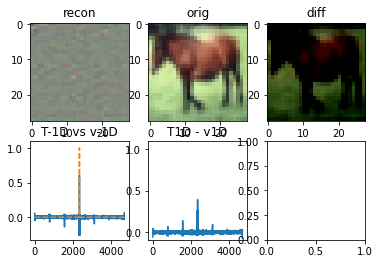

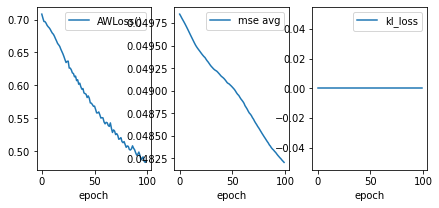

100% (100 of 100) |######################| Elapsed Time: 0:00:45 Time:  0:00:45


In [7]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi1D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [8]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss2D



Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 0, 'loss': 1.848089575767517, 'mse (validation)': 0.05090252682566643, 'kl_loss': 0.0}
 argidx T, v:  1512 7562


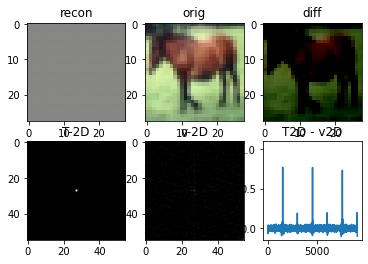

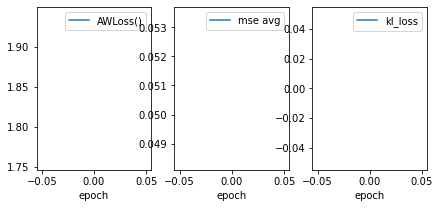

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:02
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:20
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:04
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:00
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:54
  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:37
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:36
  8% (8 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:40
  9% (9 of 100) |##                      | Elapsed Time: 0:00:04 ETA:   0:00:36
 10% (10 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:36
 11% (11 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:39
 12% (12 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:39
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 1.3782906532287598, 'mse (validation)': 0.05018271505832672, 'kl_loss': 0.0}
 argidx T, v:  1512 7562


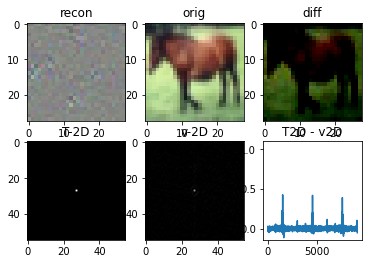

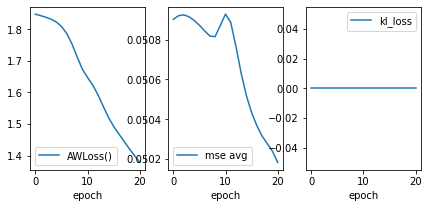

 21% (21 of 100) |####                   | Elapsed Time: 0:00:09 ETA:   0:00:30
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:28
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:27
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:27
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:26
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:27
 27% (27 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:25
 28% (28 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:24
 29% (29 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:19
 30% (30 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:19
 31% (31 of 100) |#######                | Elapsed Time: 0:00:12 ETA:   0:00:19
 32% (32 of 100) |#######                | Elapsed Time: 0:00:12 ETA:   0:00:18
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 1.0802066326141357, 'mse (validation)': 0.048228587955236435, 'kl_loss': 0.0}
 argidx T, v:  1512 7562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


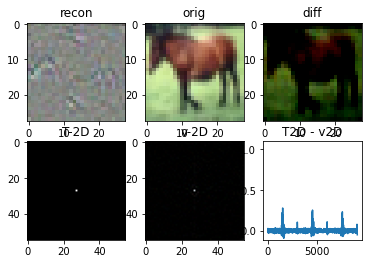

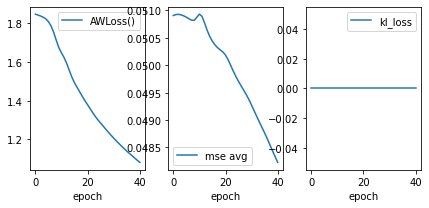

 41% (41 of 100) |#########              | Elapsed Time: 0:00:15 ETA:   0:00:24
 42% (42 of 100) |#########              | Elapsed Time: 0:00:15 ETA:   0:00:23
 43% (43 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:23
 44% (44 of 100) |##########             | Elapsed Time: 0:00:16 ETA:   0:00:22
 45% (45 of 100) |##########             | Elapsed Time: 0:00:16 ETA:   0:00:22
 46% (46 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:20
 47% (47 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:19
 48% (48 of 100) |###########            | Elapsed Time: 0:00:17 ETA:   0:00:18
 49% (49 of 100) |###########            | Elapsed Time: 0:00:17 ETA:   0:00:13
 50% (50 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:13
 51% (51 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:13
 52% (52 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:13
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 0.8977495431900024, 'mse (validation)': 0.04567180201411247, 'kl_loss': 0.0}
 argidx T, v:  1512 7562


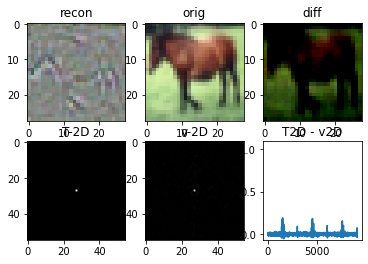

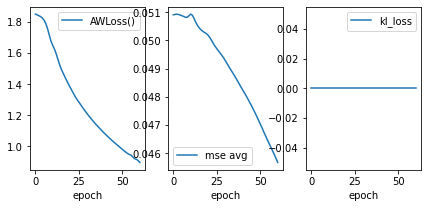

 61% (61 of 100) |##############         | Elapsed Time: 0:00:21 ETA:   0:00:13
 62% (62 of 100) |##############         | Elapsed Time: 0:00:21 ETA:   0:00:13
 63% (63 of 100) |##############         | Elapsed Time: 0:00:22 ETA:   0:00:13
 64% (64 of 100) |##############         | Elapsed Time: 0:00:22 ETA:   0:00:13
 65% (65 of 100) |##############         | Elapsed Time: 0:00:22 ETA:   0:00:12
 66% (66 of 100) |###############        | Elapsed Time: 0:00:23 ETA:   0:00:12
 67% (67 of 100) |###############        | Elapsed Time: 0:00:23 ETA:   0:00:11
 68% (68 of 100) |###############        | Elapsed Time: 0:00:23 ETA:   0:00:11
 69% (69 of 100) |###############        | Elapsed Time: 0:00:23 ETA:   0:00:08
 70% (70 of 100) |################       | Elapsed Time: 0:00:24 ETA:   0:00:08
 71% (71 of 100) |################       | Elapsed Time: 0:00:24 ETA:   0:00:08
 72% (72 of 100) |################       | Elapsed Time: 0:00:24 ETA:   0:00:07
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 0.7719927430152893, 'mse (validation)': 0.04283814877271652, 'kl_loss': 0.0}
 argidx T, v:  1512 7562


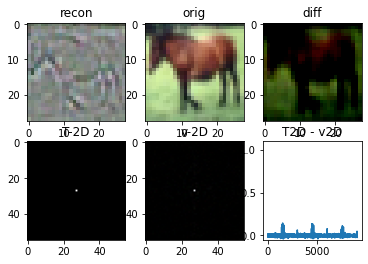

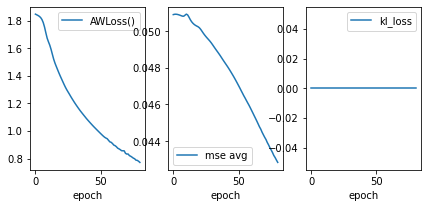

 81% (81 of 100) |##################     | Elapsed Time: 0:00:27 ETA:   0:00:06
 82% (82 of 100) |##################     | Elapsed Time: 0:00:27 ETA:   0:00:06
 83% (83 of 100) |###################    | Elapsed Time: 0:00:28 ETA:   0:00:06
 84% (84 of 100) |###################    | Elapsed Time: 0:00:28 ETA:   0:00:05
 85% (85 of 100) |###################    | Elapsed Time: 0:00:28 ETA:   0:00:05
 86% (86 of 100) |###################    | Elapsed Time: 0:00:29 ETA:   0:00:05
 87% (87 of 100) |####################   | Elapsed Time: 0:00:29 ETA:   0:00:04
 88% (88 of 100) |####################   | Elapsed Time: 0:00:29 ETA:   0:00:04
 89% (89 of 100) |####################   | Elapsed Time: 0:00:29 ETA:   0:00:03
 90% (90 of 100) |####################   | Elapsed Time: 0:00:30 ETA:   0:00:02
 91% (91 of 100) |####################   | Elapsed Time: 0:00:30 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:30 ETA:   0:00:02
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 0.693461000919342, 'mse (validation)': 0.04066135734319687, 'kl_loss': 0.0}
 argidx T, v:  1512 7562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


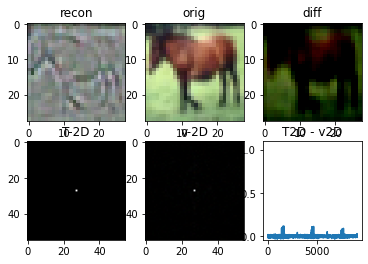

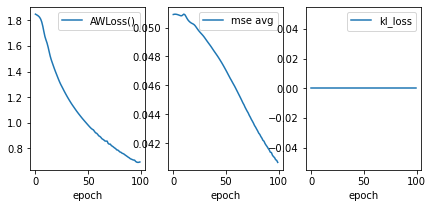

100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


In [9]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi2D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [10]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi2D, device=device)

## Training AWLoss3D



Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /tmp/pip-req-build-9n7gsq15/aten/src/ATen/native/Copy.cpp:219.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 0, 'loss': 0.6420649290084839, 'mse (validation)': 0.050542671233415604, 'kl_loss': 0.0}
 argidx T, v:  7562 7562


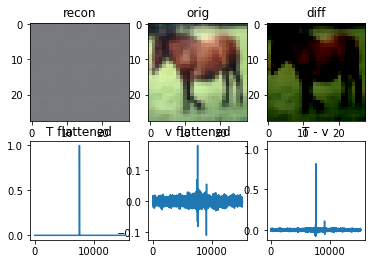

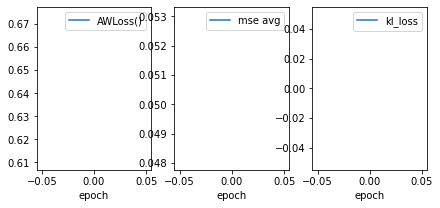

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:25
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:55
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:45
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:39
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:36
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:34
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:32
  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:31
  9% (9 of 100) |##                      | Elapsed Time: 0:00:03 ETA:   0:00:24
 10% (10 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:24
 11% (11 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:24
 12% (12 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:24
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 0.5460370182991028, 'mse (validation)': 0.050080832093954086, 'kl_loss': 0.0}
 argidx T, v:  7562 7562


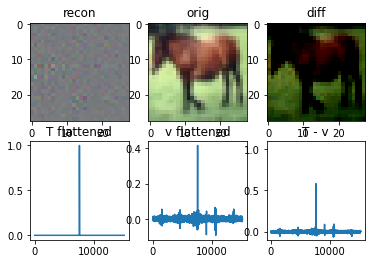

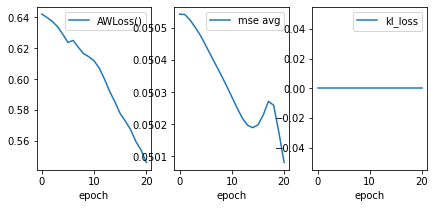

 21% (21 of 100) |####                   | Elapsed Time: 0:00:06 ETA:   0:00:29
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:29
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:29
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:28
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:08 ETA:   0:00:28
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:08 ETA:   0:00:27
 27% (27 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:26
 28% (28 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:25
 29% (29 of 100) |######                 | Elapsed Time: 0:00:09 ETA:   0:00:19
 30% (30 of 100) |######                 | Elapsed Time: 0:00:09 ETA:   0:00:18
 31% (31 of 100) |#######                | Elapsed Time: 0:00:09 ETA:   0:00:18
 32% (32 of 100) |#######                | Elapsed Time: 0:00:09 ETA:   0:00:18
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 0.4480370879173279, 'mse (validation)': 0.04876164346933365, 'kl_loss': 0.0}
 argidx T, v:  7562 7562


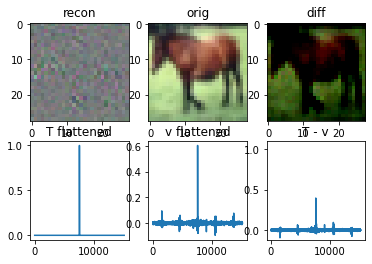

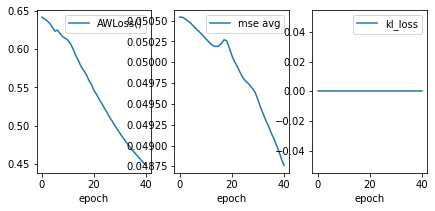

 41% (41 of 100) |#########              | Elapsed Time: 0:00:12 ETA:   0:00:21
 42% (42 of 100) |#########              | Elapsed Time: 0:00:13 ETA:   0:00:21
 43% (43 of 100) |#########              | Elapsed Time: 0:00:13 ETA:   0:00:21
 44% (44 of 100) |##########             | Elapsed Time: 0:00:13 ETA:   0:00:22
 45% (45 of 100) |##########             | Elapsed Time: 0:00:14 ETA:   0:00:22
 46% (46 of 100) |##########             | Elapsed Time: 0:00:14 ETA:   0:00:21
 47% (47 of 100) |##########             | Elapsed Time: 0:00:14 ETA:   0:00:19
 48% (48 of 100) |###########            | Elapsed Time: 0:00:15 ETA:   0:00:15
 49% (49 of 100) |###########            | Elapsed Time: 0:00:15 ETA:   0:00:14
 50% (50 of 100) |###########            | Elapsed Time: 0:00:15 ETA:   0:00:14
 51% (51 of 100) |###########            | Elapsed Time: 0:00:15 ETA:   0:00:14
 52% (52 of 100) |###########            | Elapsed Time: 0:00:16 ETA:   0:00:14
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 0.4033404290676117, 'mse (validation)': 0.04717670753598213, 'kl_loss': 0.0}
 argidx T, v:  7562 7562


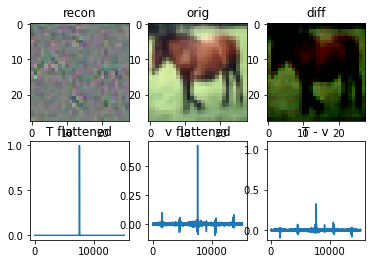

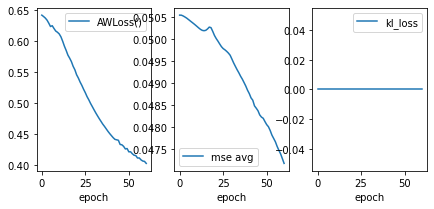

 61% (61 of 100) |##############         | Elapsed Time: 0:00:19 ETA:   0:00:15
 62% (62 of 100) |##############         | Elapsed Time: 0:00:19 ETA:   0:00:14
 63% (63 of 100) |##############         | Elapsed Time: 0:00:19 ETA:   0:00:14
 64% (64 of 100) |##############         | Elapsed Time: 0:00:20 ETA:   0:00:13
 65% (65 of 100) |##############         | Elapsed Time: 0:00:20 ETA:   0:00:13
 66% (66 of 100) |###############        | Elapsed Time: 0:00:20 ETA:   0:00:13
 67% (67 of 100) |###############        | Elapsed Time: 0:00:21 ETA:   0:00:12
 68% (68 of 100) |###############        | Elapsed Time: 0:00:21 ETA:   0:00:11
 69% (69 of 100) |###############        | Elapsed Time: 0:00:21 ETA:   0:00:08
 70% (70 of 100) |################       | Elapsed Time: 0:00:21 ETA:   0:00:08
 71% (71 of 100) |################       | Elapsed Time: 0:00:22 ETA:   0:00:08
 72% (72 of 100) |################       | Elapsed Time: 0:00:22 ETA:   0:00:07
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 0.37935972213745117, 'mse (validation)': 0.045337576419115067, 'kl_loss': 0.0}
 argidx T, v:  7562 7562


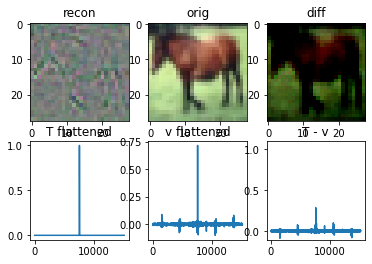

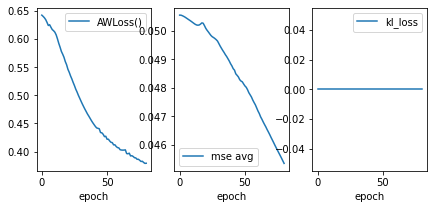

 81% (81 of 100) |##################     | Elapsed Time: 0:00:25 ETA:   0:00:07
 82% (82 of 100) |##################     | Elapsed Time: 0:00:25 ETA:   0:00:07
 83% (83 of 100) |###################    | Elapsed Time: 0:00:26 ETA:   0:00:07
 84% (84 of 100) |###################    | Elapsed Time: 0:00:26 ETA:   0:00:06
 85% (85 of 100) |###################    | Elapsed Time: 0:00:26 ETA:   0:00:06
 86% (86 of 100) |###################    | Elapsed Time: 0:00:27 ETA:   0:00:05
 87% (87 of 100) |####################   | Elapsed Time: 0:00:27 ETA:   0:00:04
 88% (88 of 100) |####################   | Elapsed Time: 0:00:27 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:27 ETA:   0:00:03
 90% (90 of 100) |####################   | Elapsed Time: 0:00:28 ETA:   0:00:02
 91% (91 of 100) |####################   | Elapsed Time: 0:00:28 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:28 ETA:   0:00:02
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 0.3638557493686676, 'mse (validation)': 0.04384472593665123, 'kl_loss': 0.0}
 argidx T, v:  7562 7562


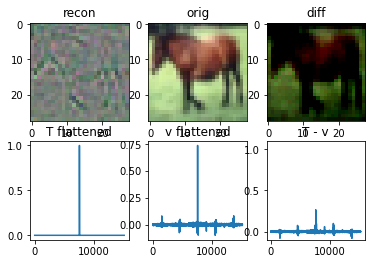

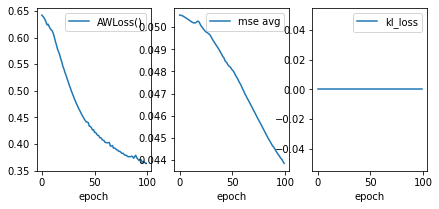

100% (100 of 100) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


In [5]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi3D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)